# Alignment and interpolation of inelastic scattering data

## Some required parameters (This section requires editing!)

In [1]:
ls

20151111  IXS-alignment-clean.ipynb


In [2]:
# the name of the file that you wish to open
specfilename = '20151111'
# the name of the x column
x = 'MCMY'
# the name of the detector (y column)
y = 'PD21'
# the name of the monitor column
monitor = 'SRcur'
# the scans that you wish to process
scans = [108, 110, 112, 114]
# the name of the output file that you are going to write
output_file_name = '-'.join([specfilename, x, y, monitor]) + '-' + '_'.join([str(scan) for scan in scans])
print('output file name is going to be: %s' % output_file_name)

output file name is going to be: 20151111-MCMY-PD21-SRcur-108_110_112_114


Specify the kind of interpolation you want to use as a string 

    'linear'
    'nearest'
    'zero'
    'slinear'
    'quadratic
    'cubic' 
    
where 'slinear', 'quadratic' and 'cubic' refer to a spline interpolation of first, second or third order) or as an integer specifying the order of the spline interpolator to use.

In [3]:
interpolation_mode = 'linear'
# The number to divide the step size by 
# use a value < 1 for more interpolated points
# use a value > 1 for less interpolated points
densify_interpolated_axis_factor = 1

## The boring stuff

### Imports

In [4]:
# Some imports that are required for this notebook
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel, LinearModel
import numpy as np
import os
import pandas as pd
%matplotlib inline

/home/edill/miniconda/envs/skx3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Defining required objects and functions

In [5]:
class Specfile:
    def __init__(self, filename):
        self.filename = os.path.abspath(filename)
        with open(self.filename, 'r') as f:
            scan_data = f.read().split('#S')
        scan_data = [section.split('\n') for section in scan_data]
        self.header = scan_data.pop(0)
        self.scans = {}
        for scan in scan_data:
            sid = int(scan[0].split()[0])
            self.scans[sid] = Specscan(self, scan)
    
    def __getitem__(self, key):
        return self.scans[key]
    
    def __len__(self):
        return len(self.scans)-1
    
    def __iter__(self):
        return (self.scans[sid] for sid in sorted(self.scans.keys()))

class Specscan:
    def __init__(self, specfile, raw_scan_data):
        self.specfile = specfile
        self.raw_scan_data = raw_scan_data
        header_row = self.raw_scan_data.pop(0).split()
        self.scan_id = int(header_row.pop(0))
        self.scan_command = header_row.pop(0)
        self.scan_args = header_row
        for row in self.raw_scan_data:
            if row.startswith('#L'):
                self.col_names = row.split()[1:]
        scan_data = [row.split() for row in self.raw_scan_data 
                     if not row.startswith('#') if row]
        self.scan_data = pd.DataFrame(data=scan_data, columns=self.col_names, dtype=float)
    def __repr__(self):
        return 'Specfile("%s")[%s]' % (self.specfile.filename, self.scan_id)

    def __str__(self):
        return str(self.scan_data)
    
    def __len__(self):
        return len(self.scan_data)

    def plot(self, column_names=None, x=None):
        if x is None:
            x = self.scan_data.columns[0]
        if column_names is None:
            column_names = self.scan_data.columns
        ncols = 2
        nrows = int(np.ceil(len(column_names)/ncols))
        try:
            self.ncols
            self.nrows
        except AttributeError:
            self.ncols = 0
            self.nrows = 0
        if self.ncols != ncols or self.nrows != nrows:
            self.ncols, self.nrows = ncols, nrows
            self.fig, self.axes = plt.subplots(nrows=nrows,
                                               ncols=ncols,
                                               figsize=(5*ncols, 2*nrows))
        self.arts = {}
        for data, ax in zip(column_names, self.axes.ravel()):
            ax.cla()
            self.arts[data] = ax.plot(self.scan_data[x], self.scan_data[data], label=data)
            ax.legend(loc=0)
            

def fit(x, y, bounds=None):
    """Fit a lorentzian + linear background to `field` in `scan`
    
    Parameters
    ----------
    scan : Specscan object
    field : The field to fit
    bounds : The +/- range to fit the data to
    
    Returns
    -------
    fit : lmfit.model.ModelFit
        The results of fitting the data to a linear + lorentzian peak
    
    Examples
    --------
    >>> fit = fit_lorentzian(scan.scan_data)
    >>> fit.plot()
    """
    lorentzian = LorentzianModel()   
    linear = LinearModel()
    center = x[np.argmax(y)]
    if bounds is None:
        lower, upper = 0, len(x)
    else:
        lower = center - bounds
        upper = center + bounds
        if lower < 0:
            lower = 0
        if upper > len(x):
            upper = len(x)
    bounds = slice(lower, upper)
#     print("Using bounds = {}".format(bounds))
    y = y[bounds]
    x = x[bounds]
#     print("Using x = {}".format(x))
#     print("Using y = {}".format(y))
    lorentzian_params = lorentzian.guess(y, x=x, center=center)
    linear_params = linear.guess(y, x=x)
    lorentzian_params.update(linear_params)
    model = lorentzian + linear
    return model.fit(y, x=x, params=lorentzian_params)

def plotter(xy):
    fig, ax = plt.subplots()
    arts = {}
    for sid, (xdata, ydata) in zip(scans, xy):
        arts[sid] = ax.plot(xdata, ydata, '-o', label=sid)
    ax.legend(loc=0)
    

## The exciting stuff!

### Open the spec file with the Specfile object defined above

In [6]:
f = Specfile(specfilename)

### Plot the raw data to make sure it looks ok

In [7]:
raw = [(
        f[scan_id].scan_data[x].values,
        f[scan_id].scan_data[y].values
    ) for scan_id in scans]

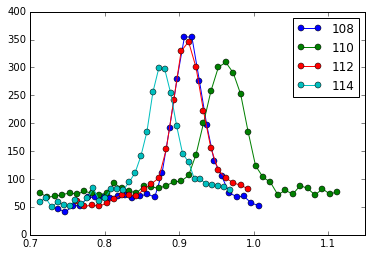

In [8]:
# Use the plotter helper function defined above
plotter(raw)

### Normalize the data by the monitor value defined in the first cell

In [9]:
normalized = [(
        x, 
        y / f[scan_id].scan_data[monitor].values
    ) for scan_id, (x, y) in zip(scans, raw)]

### Plot the normalized data to make sure it looks ok

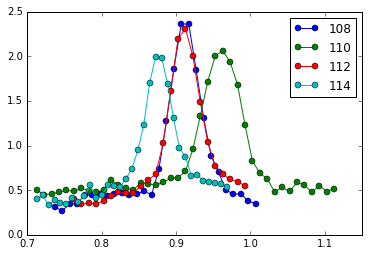

In [10]:
# Use the plotter helper function defined above
plotter(normalized)

## Fit to a linear model plus a lorentzian model

In [11]:
fits = [fit(xdata, ydata) for (xdata, ydata) in normalized]

### Plot the fits to make sure they look ok!

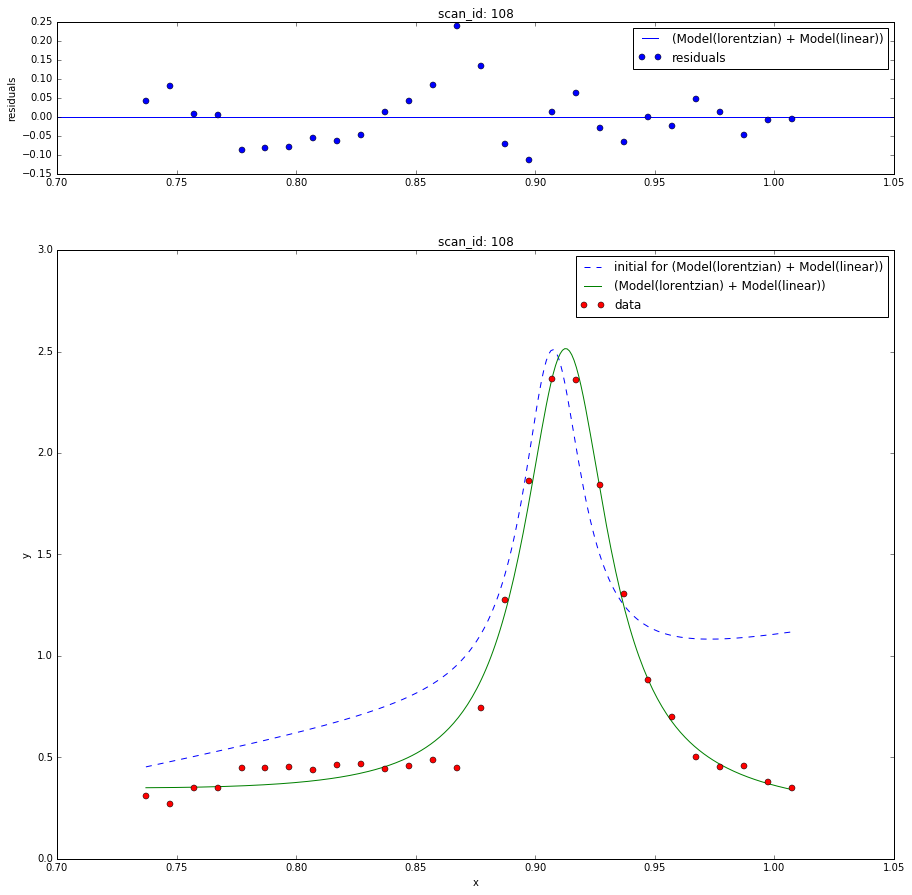

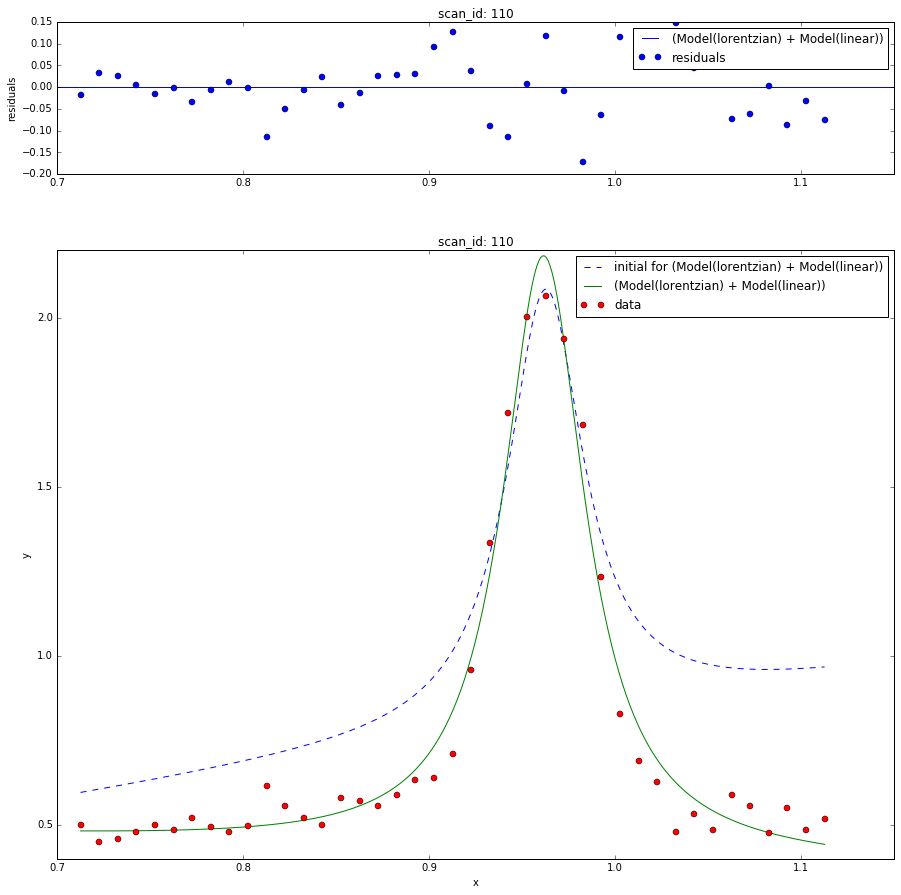

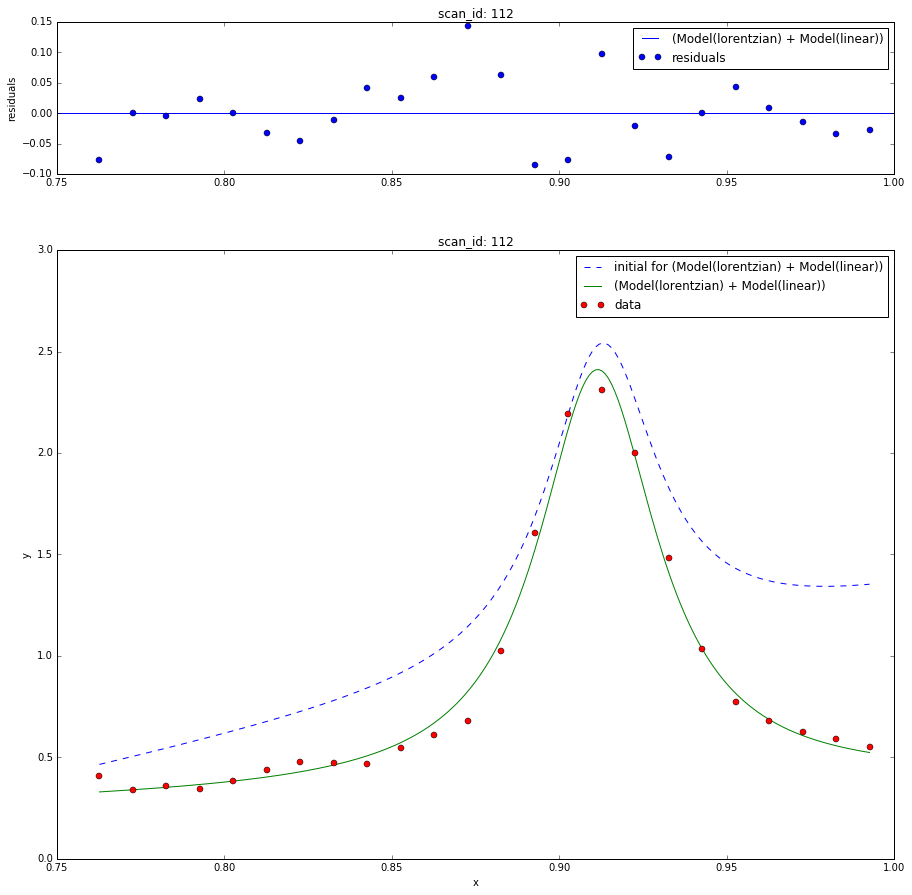

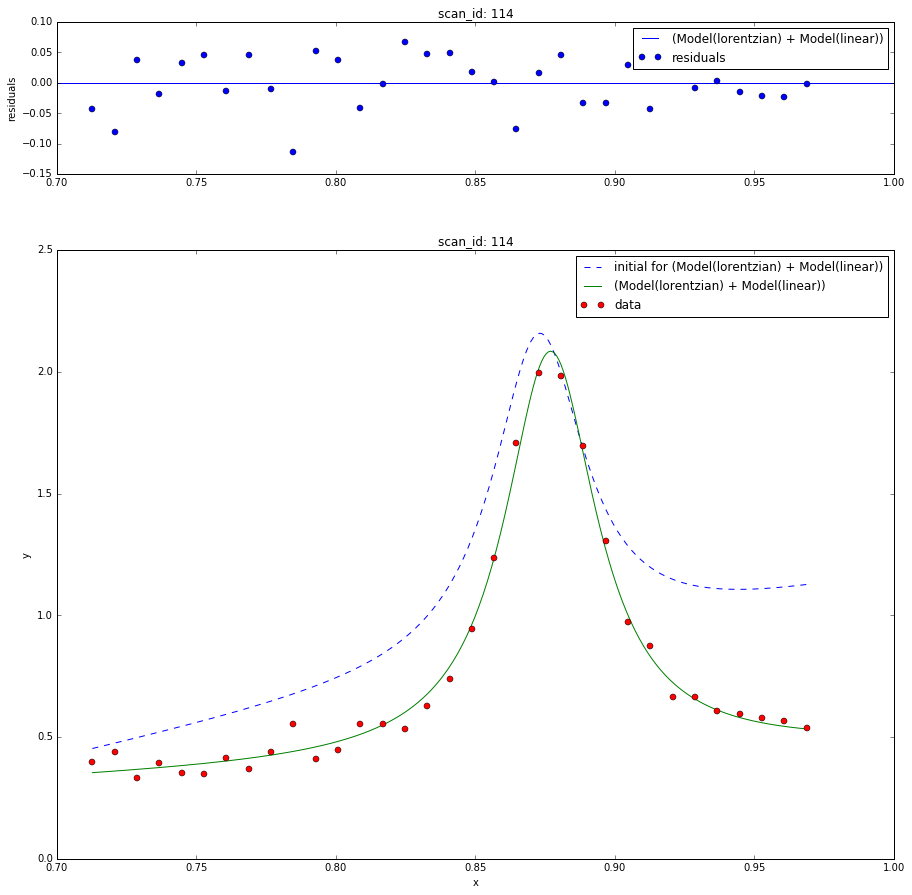

In [14]:
fig_kws = {'figsize': [15, 15]}
for sid, f in zip(scans, fits):
    title_dict = {'title': 'scan_id: %s' % sid}
    f.plot(numpoints=len(f.data)*10, ax_res_kws=title_dict,
           ax_fit_kws=title_dict, fig_kws=fig_kws)

## Shift the peaks to a zero energy transfer based on the center of the Lorentzian model

In [15]:
zeroed = [(np.array(f.userkws['x']-f.params['center'], dtype=float), f.data) for f in fits]

### Plot the shifted peaks to make sure they look ok!

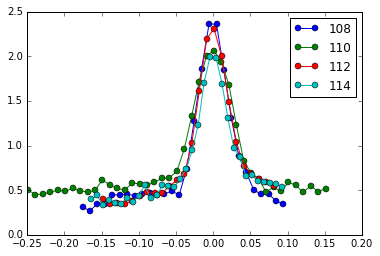

In [16]:
plotter(zeroed)

### Compute the new axis onto which the data should be interpolated

This new axis will be a linear space from the minimum value of all scans to the maximum value of all scans with a step size equal to the average step size between all data points

In [17]:
diff = np.average([np.average(np.diff(x)) for x, y in zeroed])
minval = np.min([np.min(x) for x, y in zeroed])
maxval = np.max([np.max(x) for x, y in zeroed])

In [18]:
diff, minval, maxval

(0.0095000000000000015, -0.24893695409799865, 0.15106304590200137)

In [19]:
new_axis = np.arange(minval, maxval, diff / densify_interpolated_axis_factor)

## Set up the interpolator

In [20]:
from scipy.interpolate import interp1d

In [21]:
interpolaters = [interp1d(x, y, kind=interpolation_mode, 
                          bounds_error=False, 
                          fill_value=np.nan) 
                 for x, y in zeroed]

In [22]:
# Create a dict of the interpolated values so it can easily be passed to pandas
interpolated = {sid: interpolator(new_axis) 
          for sid, interpolator in zip(scans, interpolaters)}

In [23]:
df = pd.DataFrame(interpolated, index=new_axis)

### Plot the new interpolated values

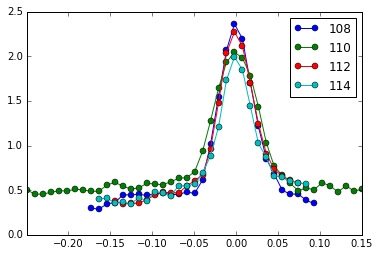

In [24]:
df.plot(style='-o')

### Just take the straight sum of all data in the data frame

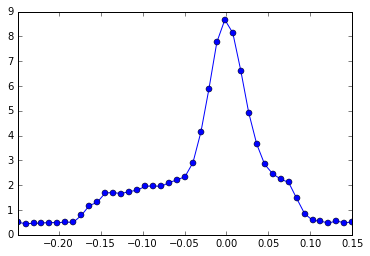

In [25]:
df.sum(axis=1).plot(style='-o')

### Ok, that looks a little weird, let's divide the sum by the number of channels at each x value

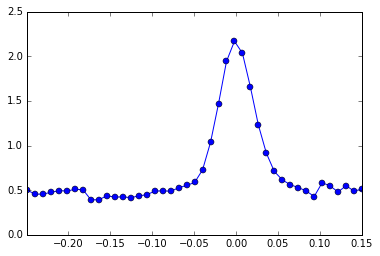

In [26]:
(df.sum(axis=1) / df.count(axis=1)).plot(style='-o')

### Hmm, that still looks a little strange, lets just sum the channels where they **all** have values

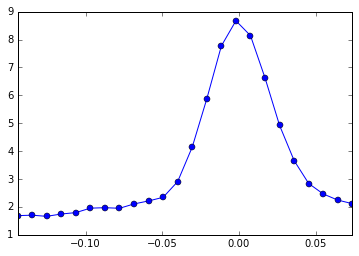

In [27]:
df.dropna().sum(axis=1).plot(style='-o')

## Output the data

In [28]:
df.dropna().sum(axis=1).to_csv(output_file_name, encoding='ascii', sep=',')

### Show that we actually output the data...

In [29]:
!cat 20151111-MCMY-PD21-SRcur-108_110_112_114

-0.14443695409799856,1.6874376948858338
-0.13493695409799855,1.702554060125234
-0.12543695409799854,1.6616389916220111
-0.11593695409799853,1.7451558841638257
-0.10643695409799853,1.795428105240191
-0.09693695409799852,1.955000474391327
-0.08743695409799851,1.9717883589338725
-0.0779369540979985,1.9503549846016142
-0.06843695409799849,2.106210881404486
-0.058936954097998484,2.2141358308099015
-0.049436954097998476,2.3436653558440663
-0.03993695409799847,2.9097530034516734
-0.03043695409799846,4.146455166987938
-0.02093695409799845,5.873590301247516
-0.011436954097998442,7.770183051573352
-0.0019369540979984334,8.671919241394221
0.007563045902001575,8.13868563734535
0.017063045902001583,6.622442119962967
0.026563045902001592,4.919072889735574
0.0360630459020016,3.6586377836230515
0.04556304590200161,2.8385456343052025
0.05506304590200162,2.463075097632073
0.06456304590200163,2.243716355738397
0.07406304590200163,2.116251638483118


## If you are working in the notebook and want to download this data file to your local computer, follow these steps:

1. Figure out where that file lives with `!pwd`
2. Remember the file name given by: `print(output_file_name)`
3. Now that you know where the file lives, go back to the home page of jupyter hub by right clicking on the Jupyter icon in the top-left of this page and selecting "Open in new tab"
4. Then go to that new tab, navigate to the folder that was shown by `!pwd` and open the file named `output_file_name`, shown above
5. Finally, open the file by left-clicking on it.  Once it opens, select File -> Download

In [30]:
!pwd

/home/edill/dev/python/scikit-beam-examples/demos/inelastic


In [31]:
print(output_file_name)

20151111-MCMY-PD21-SRcur-108_110_112_114
